<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Conversations with Chat History Compression Enabled (Experimental)

AutoGen offers conversable agents powered by LLM, tools, or humans, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participance through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to enable compression of history messages using the `CompressibleAgent`. While this agent retains all the default functionalities of the `AssistantAgent`, it also provides the added feature of compression when activated through the `compress_config` setting.

Different compression modes are supported:
1. `compress_config=False` (Default): `CompressibleAgent` is equivalent to `AssistantAgent`.
2. `compress_config=True` or `compress_config={"mode": "TERMINATE"}`: no compression will be performed. However, we will count token usage before sending requests to the OpenAI model. The conversation will be terminated directly if the total token usage exceeds the maximum token usage allowed by the model (to avoid the token limit error from OpenAI API).
3. `compress_config={"mode": "COMPRESS", "trigger_count": <your pre-set number>}, "leave_last_n": <your pre-set number>`: compression is enabled.
    ```
    # default compress_config
    compress_config = {
        "mode": "COMPRESS",
        "compress_function": None,
        "trigger_count": 0.7, # default to 0.7, or your pre-set number
        "broadcast": True,

        # the following settings are for this mode only
        "leave_last_n": 2, # leave the last n messages in the history to avoid compression
        "verbose": False, # if True, print out the content to be compressed and the compressed content
    }
    ```
    Currently, our compression logic is as follows:
        1. We will leave the first user message (as well as system prompts) and compress the rest of the history messages.
        2. The summary is performed on a per-message basis, with the role of the messages (See compressed content in the example below).

4. `compress_config={"mode": "CUSTOMIZED", "compress_function": <A customized function for compression>}`: the `compress_function` function will be called on trigger count. The function should accept a list of messages as input and return a tuple of (is_success: bool, compressed_messages: List[Dict]). The whole message history (except system prompt) will be passed.


By adjusting `trigger_count`, you can decide when to compress the history messages based on existing tokens. If this is a float number between 0 and 1, it is interpreted as a ratio of max tokens allowed by the model. For example, the AssistantAgent uses gpt-4 with max tokens 8192, the trigger_count = 0.7 * 8192 = 5734.4 -> 5734. Do not set `trigger_count` to the max tokens allowed by the model, since the same LLM is employed for compression and it needs tokens to generate the compressed content. 



## Limitations
- For now, the compression feature **is not well-supported for groupchat**. If you initialize a `CompressibleAgent` in a groupchat with compression, the compressed cannot be broadcast to all other agents in the groupchat. If you use this feature in groupchat, extra cost will be incurred since compression will be performed on at per-agent basis.
- We do not support async compression for now.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
# %pip install pyautogen~=0.1.0

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [ ]:
import autogen
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well).

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Example 1
This example is from [agentchat_MathChat.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_MathChat.ipynb). Compression with code execution.

In [1]:
config_list = [
    {
        'model': 'gpt-4',
        'api_key': open('key_openai.txt', 'r').read().strip(),

    },
]

In [2]:
import autogen
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent
from autogen.agentchat.contrib.compressible_agent import CompressibleAgent
# 1. replace AssistantAgent with CompressibleAgent
assistant = CompressibleAgent(
    name="assistant", 
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "seed": 42,
        "config_list": config_list,
    },
    compress_config={
        "mode": "COMPRESS",
        "trigger_count": 600, # set this to a large number for less frequent compression
        "verbose": True, # to allow printing of compression information
        "leave_last_n": 2,
    }
)

# 2. create the MathUserProxyAgent instance named "mathproxyagent"
mathproxyagent = MathUserProxyAgent(
    name="mathproxyagent", 
    human_input_mode="NEVER",
    code_execution_config={"use_docker": False},
    max_consecutive_auto_reply=5,
)
math_problem = "Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation."
mathproxyagent.initiate_chat(assistant, problem=math_problem)

mathproxyagent (to assistant):

Let's use Python to solve a math problem.

Query requirements:
You should always use the 'print' function for the output and use fractions/radical forms instead of decimals.
You can use packages like sympy to help you.
You must follow the formats below to write your code:
```python
# your code
```

First state the key idea to solve the problem. You may choose from three ways to solve the problem:
Case 1: If the problem can be solved with Python code directly, please write a program to solve it. You can enumerate all possible arrangements if needed.
Case 2: If the problem is mostly reasoning, you can solve it by yourself directly.
Case 3: If the problem cannot be handled in the above two ways, please follow this process:
1. Solve the problem step by step (do not over-divide the steps).
2. Take out any queries that can be asked through Python (for example, any calculations or equations that can be calculated).
3. Wait for me to give the results.
4. Continu

assistant (to mathproxyagent):

I apologize for the oversight. It seems like the function is returning NaN error. Because we are dealing with real numbers, NaN (Not a Number) error could arise from operations that don't return a defined real number. 

However, in this case, we it seems there's a problem with the comparison of symbolic terms with zero in the function test_intervals.

Let's correct this approach. The error arises from trying to compare a symbolic expression to zero directly. Instead, we can create a numeric function from our symbolic expression, and use this function to test the intervals. 

Here is the revised code:

```python
from sympy import *
from sympy.abc import x

# define the equation
equation = expand((2*x+10)*(x+3) - (3*x+9)*(x+8))

# set the equation equal to zero to find the critical points
critical_points = solve(equation, x)

# Convert the points to standard python floats, so that they can be sorted numerically
critical_points = [N(i) for i in critical_poi

## Example 2
This example is from [agentchat_function_call.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb). Compression with function calls. 

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\nimport numpy as np\n\nfig, ax = plt.subplots()\n\nagent_a = [(1, 1), (2, 2), (3, 4), (4, 2), (5, 1)]\nagent_b = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]\ndialog = ['Hi', 'Hello', 'How are you?', 'Good, you?', 'Great']\n\nfor i, txt in enumerate(dialog):\n    ax.annotate(txt, (agent_a[i][0], agent_a[i][1]))\n    ax.annotate(txt, (agent_b[i][0], agent_b[i][1]))\n\nax.plot(*zip(*agent_a), marker='o')\nax.plot(*zip(*agent_b), marker='o')\n\nplt.xlabel('Time')\nplt.ylabel('Statement Sequence')\nplt.title('Dialog between two agents')\nplt.grid(True)\n"
}
*******************************************

-----------------------------------------------------------------------------

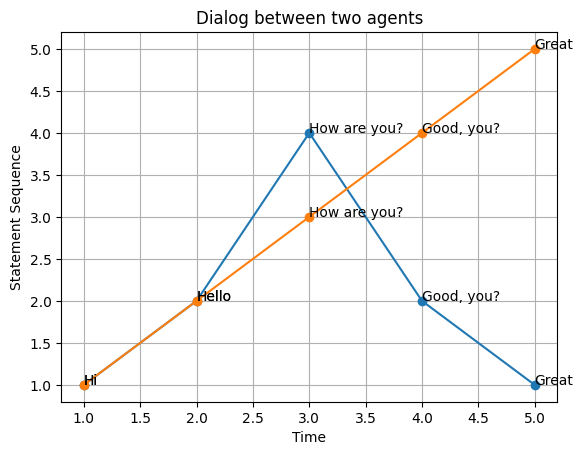

user_proxy (to chatbot):

***** Response from calling function "python" *****
None
***************************************************

--------------------------------------------------------------------------------
******************************Start compressing the following content:******************************
To be compressed:
##FUNCTION_CALL## 
Name: python
Args: {
  "cell": "import matplotlib.pyplot as plt\nimport numpy as np\n\nfig, ax = plt.subplots()\n\nagent_a = [(1, 1), (2, 2), (3, 4), (4, 2), (5, 1)]\nagent_b = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]\ndialog = ['Hi', 'Hello', 'How are you?', 'Good, you?', 'Great']\n\nfor i, txt in enumerate(dialog):\n    ax.annotate(txt, (agent_a[i][0], agent_a[i][1]))\n    ax.annotate(txt, (agent_b[i][0], agent_b[i][1]))\n\nax.plot(*zip(*agent_a), marker='o')\nax.plot(*zip(*agent_b), marker='o')\n\nplt.xlabel('Time')\nplt.ylabel('Statement Sequence')\nplt.title('Dialog between two agents')\nplt.grid(True)\n"
}
##FUNCTION_RETURN## (from

In [4]:
llm_config = {
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "timeout": 120,
}
chatbot = CompressibleAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
    compress_config={
        "mode": "COMPRESS",
        "trigger_count": 300, # set this to a large number for less frequent compression
        "verbose": True, # set this to False to suppress the compression log
        "leave_last_n": 0,
    }
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# define functions according to the function desription
from IPython import get_ipython

def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log

def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])

# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)


## Example 3
This example is from [agent_chat_web_info.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_web_info.ipynb). 
We use to demonstrate how to pass in a customized compression function. Here an example function `constrain_num_messages` is used, which constrains the number of messages to be 3 or less (excluding system message). 
The customized function should accept a list of messages as input and return a tuple of (is_success: bool, compressed_messages: List[Dict]).

In [8]:
import autogen
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent
from autogen.agentchat.contrib.compressible_agent import CompressibleAgent

def constrain_num_messages(messages):
    """Constrain the number of messages to 3.
    
    This is an example of a customized compression function.
    """
    if len(messages) <= 3:
        # do nothing
        return False, None
    
    # save the first and last two messages
    return True, messages[:1] + messages[-2:]

# create a CompressibleAgent instance named "assistant"
assistant = CompressibleAgent(
    name="assistant",
    llm_config={
        "timeout": 600,
        "seed": 43,
        "config_list": config_list,
    },
    compress_config={
        "mode": "CUSTOMIZED",
        "compress_function": constrain_num_messages,  # this is required for customized compression
        "trigger_count": 1600, 
    },
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="TERMINATE",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith("TERMINATE."),
    code_execution_config={"work_dir": "web"},
    system_message="""Reply TERMINATE if the task has been solved at full satisfaction.
Otherwise, reply CONTINUE, or the reason why the task is not solved yet."""
)

user_proxy.initiate_chat(
    assistant,
    message="""Show me the YTD gain of 10 largest technology companies as of today.""",
)


user_proxy (to assistant):

Show me the YTD gain of 10 largest technology companies as of today.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To fulfill your request, we first need a list of the 10 largest technology companies by market cap. Unfortunately, real-time financial data is gated behind paywalls, so it's difficult to get up-to-date reliable information through coding here. 

However, I can provide you a script to download YTD performance for a given list of companies if you already know the list. Below is an example using Yahoo Finance, for which Python has a usable API.

Frequently mentioned largest technology companies include: Apple (AAPL), Microsoft (MSFT), Alphabet (GOOGL), Amazon (AMZN), Meta (FB), Tesla (TSLA), Alibaba group holding (BABA), Taiwan Semiconductor (TSM), Tencent (TCEHY), Oracle (ORCL). Adjust as necessary for your purpose.

First, we need to install yfinance module:

```sh
pip install yfinan

execute_code was called without specifying a value for use_docker. Since the python docker package is not available, code will be run natively. Note: this fallback behavior is subject to change



>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is python)...


execute_code was called without specifying a value for use_docker. Since the python docker package is not available, code will be run natively. Note: this fallback behavior is subject to change


user_proxy (to assistant):

exitcode: 1 (execution failed)
Code output: 

ytd_gain.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_price = ticker_data['Close'][0]
ytd_gain.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_recent_price = ticker_data['Close'][-1]
ytd_gain.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_price = ticker_data['Close'][0]
ytd_gain.py:22: FutureWarning: Series.__getitem__ t

execute_code was called without specifying a value for use_docker. Since the python docker package is not available, code will be run natively. Note: this fallback behavior is subject to change



>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is sh)...


execute_code was called without specifying a value for use_docker. Since the python docker package is not available, code will be run natively. Note: this fallback behavior is subject to change


user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 

[*********************100%%**********************]  1 of 1 completed
The YTD return for AAPL is 34.50%

[*********************100%%**********************]  1 of 1 completed
The YTD return for MSFT is 37.66%

[*********************100%%**********************]  1 of 1 completed
The YTD return for GOOGL is 37.08%

[*********************100%%**********************]  1 of 1 completed
The YTD return for AMZN is 48.85%

[*********************100%%**********************]  1 of 1 completed
The YTD return for META is 137.88%

[*********************100%%**********************]  1 of 1 completed
The YTD return for TSLA is 91.77%

[*********************100%%**********************]  1 of 1 completed
The YTD return for BABA is -9.96%

[*********************100%%**********************]  1 of 1 completed
The YTD return for TSM is 16.16%

[*********************100%%**********************]  1 of 1 completed
The YTD return for TC